In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Import libraries.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.linear_model import LogisticRegression

# Table of Contents

1. [Differential Privacy Mechanisms: An Overview](#differential-privacy-mechansism-an-overview)
2. [Laplace Mechanism for Noisy Gene Expression Data](#laplace-mechanism-for-noisy-gene-expression-data)
3. [Gaussian Mechanism for Differential Priacy](#dp-sgd-mechanism-with-gaussian-noise)

## Differential Privacy Mechanisms: An Overview
Differential privacy (DP) offers a principled way to analyze sensitive genomic data while provably protecting each individual's privacy. At its core, a DP mechanism perturbs true query results by augmenting the data with carefully callibrated random noise, such that the inclusion or exclusion of any one patient's data will have a minimal effect on statistics published thereafter. One of the most common DP-noise implementations is the **Laplace Mechanism**, which injects noise drawn from a Laplace (double-exponential) distribution scaled to a query's sensitivity (i.e., how much the query's output will change when its input changes). This approache aims to balance privacy (by obscuring any one individual's genomic influence) with utility (by retaining enough signal to discover whether genetic markets are associated with a given condition), thereby enabling researchers to perform meaningful population-level analyses without exposing individuals' genomic sequences.

This project applies differential privacy to a real-world, high-dimensional genomic dataset of endometriosis patients. We utilize a dataset of 660 patient samples, each with 28,247 gene measurements plus a binary label that determines whether the patient suffers from endometriosis. Within this context, we design and evaluate a differential privacy mechanism that injects calibrated Laplace noise directly into each gene-epression feature, scaling the noise to each gene's empirical range and our overall privacy budget (𝜀).

In [4]:
# Import the pre-processed data.
# note: data has been pre-processed to clean and address class imbalance.
endometriosis = pd.read_csv('/content/drive/MyDrive/CS2080 Final Project/data/endometriosis_dataset.csv')
endometriosis.head()

,disease,RERE_ILMN_1802380,LOC105374121_ILMN_1736104,CIDEA_ILMN_1788184,SLC17A3_ILMN_1690979,ATP6V1C2_ILMN_1660729,ZNF768_ILMN_1791820,F3_ILMN_2129572,HTR5BP_ILMN_1858692,LINC00999_ILMN_3239930,...,ZSCAN26_ILMN_1651905,ZSCAN4_ILMN_1725718,ZSWIM3_ILMN_1684960,ZSWIM8_ILMN_1669433,ZWINT_ILMN_1673117,ZXDA_ILMN_1713868,ZYG11A_ILMN_1794932,ZYG11A_ILMN_1723439,ZYX_ILMN_1701875,ZZZ3_ILMN_1653618
0,1,11.449473,6.536105,7.542748,6.438908,6.484894,8.762321,8.017512,6.269659,6.840264,...,6.668651,6.646208,6.395408,11.444387,6.398342,6.517778,6.363869,6.245223,11.967503,9.494950
1,1,11.661547,6.702027,7.018477,6.409870,8.473473,7.425452,8.959437,6.519406,6.686117,...,6.630572,6.517468,6.096741,10.647588,6.555686,6.458170,6.306452,6.481059,11.720273,9.595461
2,1,12.653095,6.538306,6.540266,6.322736,6.448993,8.177972,8.622699,6.416195,6.727923,...,6.688430,6.654922,6.334504,11.617943,6.585496,6.491730,6.342675,6.438649,11.875686,9.422292
3,1,12.166617,6.478355,6.798654,6.423690,6.578178,8.552622,9.233912,6.321077,6.596769,...,6.496436,6.433557,6.294022,11.580790,6.649865,6.449307,6.383782,6.429199,12.424216,8.633182
4,1,12.008305,6.488900,6.612325,6.338658,7.149825,8.410684,9.194004,6.317384,6.845715,...,6.798702,6.462172,6.393570,11.435183,6.451736,6.499047,6.341496,6.397282,11.310392,9.688721


## Laplace Mechanism for Noisy Gene Expression Data

In [5]:
def noisydata(data: pd.DataFrame, epsilon: float) -> pd.DataFrame:
    """
    Applies the Laplace mechanism to add noise to each feature column for differential privacy.
    Uses two-step mean + residual perturbation under a public bound of [0, 20], which covers the
    full range of log-transformed RNA-sequencing expression values in almost every practical dataset.

    Parameters:
            data (pd.DataFrame): input dataset.
            epsilon (float): privacy budget for differential privacy.

    Returns:
            pd.DataFrame: A DataFrame of the same shape as `data`, with Laplace noise added to each feature.
            The 'disease' column, if present, is left unchanged.
    """
    # Check if the target variable 'disease' is present in the data.
    if 'disease' in data.columns:
        X = data.drop(columns = ['disease'])
    else:
        X = data.copy()

    # Use public bounds [0, 20] for the features.
    a_public = pd.Series(0, index = X.columns)
    b_public = pd.Series(20, index = X.columns)

    # Clip the data to public [a, b].
    X_clipped = X.clip(lower = a_public, upper = b_public, axis = 1)

    # Split the privacy budget equally between the mean and residual perturbation.
    eps_mean = epsilon / 2
    eps_residual = epsilon / 2

    # Compute the true column means.
    n = len(X_clipped)
    mu = X_clipped.mean(axis = 0)

    # Privatize the means with Laplace ((U-L)/(n*eps_mean))
    sensitivity_mean = (b_public - a_public) / n
    scale_mean = sensitivity_mean / eps_mean
    noise_mean = np.random.laplace(loc = 0, scale = scale_mean.values, size = scale_mean.shape)
    mu_noisy = pd.Series(mu.values + noise_mean, index = X.columns)

    # Center on the noisy means.
    R = X_clipped.subtract(mu_noisy, axis = 1)

    # Compute the public residual bounds ((U-L)/2) = 10.
    D = (b_public - a_public) / 2

    # Clip the residuals to public bounds.
    R_clipped = R.clip(lower = -D, upper = D, axis = 1)

    # Privatize residuals with Laplace (2D / eps_residual).
    sensitivity_residual = 2 * D
    scale_residual = sensitivity_residual / eps_residual
    noise_residual = np.random.laplace(loc = 0 , scale = scale_residual.values, size = R_clipped.shape)
    R_noisy = pd.DataFrame(R_clipped.values + noise_residual, columns = X.columns, index = X.index)
    X_noisy = R_noisy.add(mu_noisy, axis = 1)
    noisydata = X_noisy

    # If 'disease' column is present, add it back to the noisy data.
    if 'disease' in data.columns:
        noisydata['disease'] = data['disease']

    # Return the noisy data.
    return noisydata

In [8]:
# Set the privacy budget.
epsilons = [.001, .01, .1, 1, 10]

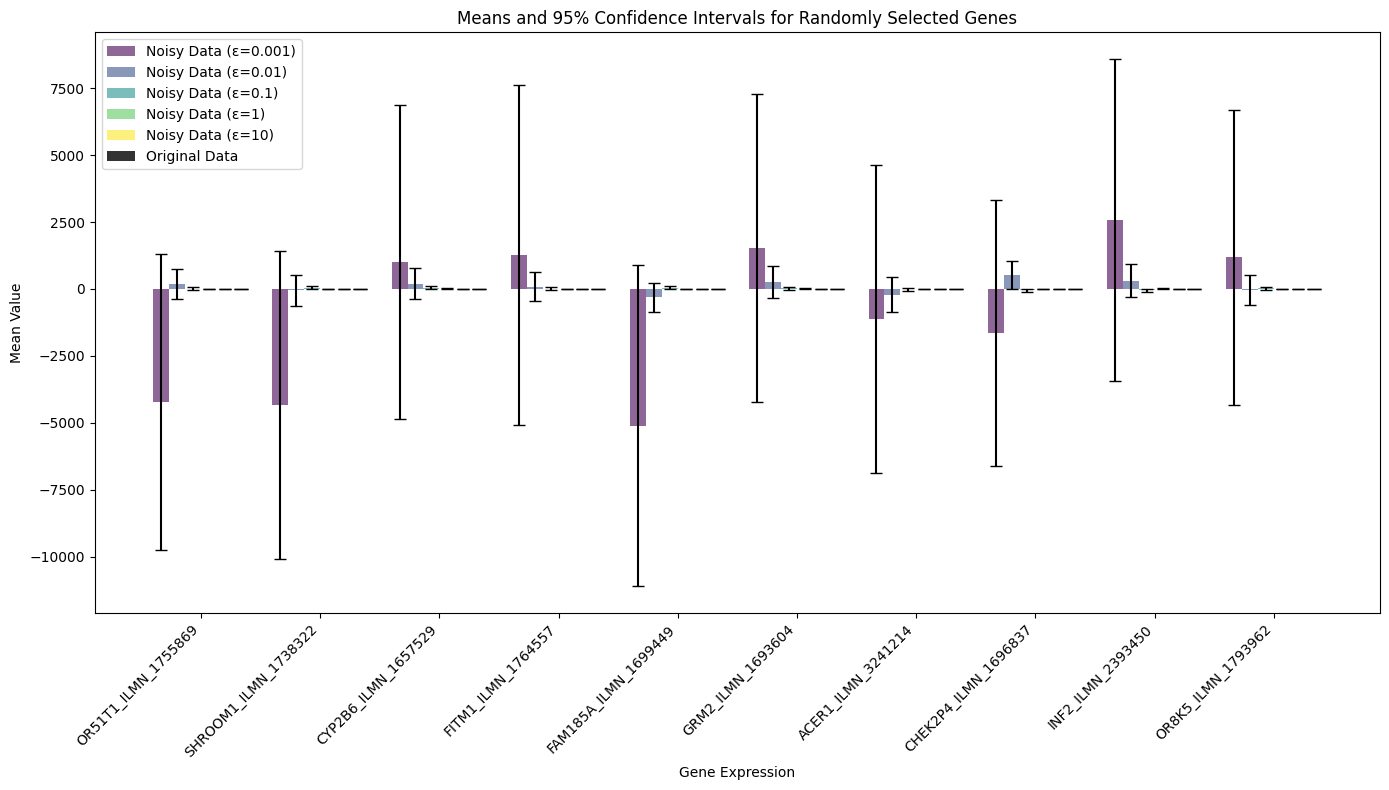

In [11]:
colors = plt.cm.viridis(np.linspace(0, 1, len(epsilons)))  # Different colors for each epsilon

# Randomly select 10 columns once
selected_columns = np.random.choice(endometriosis.columns[:-1], size=10, replace=False)

x = np.arange(len(selected_columns))  # base x locations
width = 0.8 / (len(epsilons) + 1)  # width of each bar

fig, ax = plt.subplots(figsize=(14, 8))

# Plot each epsilon
for i, (epsilon, color) in enumerate(zip(epsilons, colors)):
    # Generate noisy data for this epsilon
    noisy_endometriosis = noisydata(endometriosis, epsilon)

    # Compute stats
    noisystats = pd.DataFrame({
        'mean': noisy_endometriosis[selected_columns].mean(),
        'lower_bound': noisy_endometriosis[selected_columns].mean() - 1.96 * noisy_endometriosis[selected_columns].std() / np.sqrt(len(noisy_endometriosis)),
        'upper_bound': noisy_endometriosis[selected_columns].mean() + 1.96 * noisy_endometriosis[selected_columns].std() / np.sqrt(len(noisy_endometriosis))
    })

    # Plot bars with error bars
    ax.bar(x + (i - len(epsilons)/2) * width, noisystats['mean'], width,
           yerr=[noisystats['mean'] - noisystats['lower_bound'], noisystats['upper_bound'] - noisystats['mean']],
           label=f'Noisy Data (ε={epsilon})', color=color, alpha=0.6, capsize=4)

# Plot original data for reference (black bars)
ogstats = pd.DataFrame({
    'mean': endometriosis[selected_columns].mean(),
    'lower_bound': endometriosis[selected_columns].mean() - 1.96 * endometriosis[selected_columns].std() / np.sqrt(len(endometriosis)),
    'upper_bound': endometriosis[selected_columns].mean() + 1.96 * endometriosis[selected_columns].std() / np.sqrt(len(endometriosis))
})
ax.bar(x + (len(epsilons)/2) * width, ogstats['mean'], width,
       yerr=[ogstats['mean'] - ogstats['lower_bound'], ogstats['upper_bound'] - ogstats['mean']],
       label='Original Data', color='black', alpha=0.8, capsize=5)

# Formatting
ax.set_xticks(x)
ax.set_xticklabels(selected_columns, rotation=45, ha='right')
ax.set_title('Means and 95% Confidence Intervals for Randomly Selected Genes')
ax.set_ylabel('Mean Value')
ax.set_xlabel('Gene Expression')
ax.legend()
plt.tight_layout()
plt.show()